# CareForHospitals: State-Level Hospital Stress Forecasting

This notebook implements a complete machine learning pipeline for predicting hospital stress indicators across U.S. states using weekly hospital data.

The system predicts:
- Next-week ICU occupancy 
- Next-week inpatient bed occupancy 
- Next-week critical stress risk 
- Next-week disease burden (COVID / Flu / RSV)

The notebook includes:
- Data inspection
- Feature engineering
- Model experimentation (including failed models)
- Model evaluation
- Model selection
- Real-time next-week forecasting
- State-level risk ranking

## 1. Load Clean Data

Loading the cleaned datasets generated from the preprocessing pipeline.
These datasets are already normalized, filtered to 50 U.S. states, and structured for modeling.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

state_week = pd.read_csv("../data/cleaned/CareForHospitalsCleanedData.csv")
model_ready = pd.read_csv("../data/cleaned/model_ready.csv")

state_week["Week Ending Date"] = pd.to_datetime(state_week["Week Ending Date"])
model_ready["Week Ending Date"] = pd.to_datetime(model_ready["Week Ending Date"])

print("State-week shape:", state_week.shape)
print("Model-ready shape:", model_ready.shape)


State-week shape: (3200, 18)
Model-ready shape: (3050, 28)


## 2. Data Quick Checks

Verifiying:
- Missing values
- Data types
- Date ranges
- State coverage
This ensures the dataset is clean & safe for modeling.


In [2]:
display(state_week.isna().mean())
print("States:", state_week["Geographic aggregation"].nunique())
print("Date range:", state_week["Week Ending Date"].min(), "→", state_week["Week Ending Date"].max())


Geographic aggregation                                  0.0
Week Ending Date                                        0.0
Number of Inpatient Beds                                0.0
Number of Inpatient Beds Occupied                       0.0
Number of ICU Beds                                      0.0
Number of ICU Beds Occupied                             0.0
Percent Inpatient Beds Occupied                         0.0
Percent ICU Beds Occupied                               0.0
Total Patients Hospitalized with COVID-19               0.0
Total Patients Hospitalized with Influenza              0.0
Total Patients Hospitalized with RSV                    0.0
Total ICU Patients Hospitalized with COVID-19           0.0
Total ICU Patients Hospitalized with Influenza          0.0
Total ICU Patients Hospitalized with RSV                0.0
Number Hospitals Reporting Number of Inpatient Beds     0.0
Number Hospitals Reporting Number of ICU Beds           0.0
Percent Hospitals Reporting Number of In

States: 50
Date range: 2024-11-09 00:00:00 → 2026-01-10 00:00:00


## 3. Feature Overview

Inspecting the main predictive signals used in modeling:
- ICU capacity
- Inpatient capacity
- Disease burden
- Stress indicators


In [3]:
state_week.describe()


,Week Ending Date,Number of Inpatient Beds,Number of Inpatient Beds Occupied,Number of ICU Beds,Number of ICU Beds Occupied,Percent Inpatient Beds Occupied,Percent ICU Beds Occupied,Total Patients Hospitalized with COVID-19,Total Patients Hospitalized with Influenza,Total Patients Hospitalized with RSV,Total ICU Patients Hospitalized with COVID-19,Total ICU Patients Hospitalized with Influenza,Total ICU Patients Hospitalized with RSV,Number Hospitals Reporting Number of Inpatient Beds,Number Hospitals Reporting Number of ICU Beds,Percent Hospitals Reporting Number of Inpatient Beds,Percent Hospitals Reporting Number of ICU Beds
count,3100,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000
mean,2025-06-10 12:00:00.000000256,13424.242903,9904.105484,2022.901290,1435.086774,71.768065,69.006129,114.550645,143.613871,43.173226,15.840323,23.440645,8.688387,94.345484,87.287419,83.363871,76.889677
min,2024-11-09 00:00:00,709.000000,207.000000,31.000000,11.000000,27.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000,22.000000,22.000000
25%,2025-02-22 00:00:00,4263.750000,2503.250000,461.750000,313.750000,68.000000,65.000000,22.000000,6.000000,2.000000,2.000000,1.000000,0.000000,42.000000,37.000000,78.000000,71.000000
50%,2025-06-10 12:00:00,9766.000000,7032.500000,1361.000000,956.500000,73.000000,71.000000,55.000000,23.000000,10.000000,7.000000,4.000000,2.000000,84.000000,78.000000,84.000000,78.000000
75%,2025-09-27 00:00:00,16307.000000,12382.250000,2572.250000,1761.250000,77.000000,75.000000,133.000000,114.000000,44.000000,19.000000,19.000000,9.000000,122.000000,110.000000,90.000000,84.000000
max,2026-01-10 00:00:00,64473.000000,50830.000000,11113.000000,8300.000000,89.000000,92.000000,1197.000000,3209.000000,865.000000,221.000000,571.000000,171.000000,430.000000,392.000000,100.000000,100.000000
std,NaN,13868.638851,10631.297480,2204.293357,1583.103678,8.731635,9.585553,160.271481,325.422630,84.775630,22.865743,53.055652,17.329271,76.469211,72.815310,9.281054,11.042326


## 4. Feature Engineering

Defining the feature set used for prediction and modeling.
This includes lag features and hospital stress indicators.


In [7]:
feature_cols = [
    # Capacity & stress
    "Percent ICU Beds Occupied",
    "Percent Inpatient Beds Occupied",

    # Lag features
    "icu_pct_last_week",
    "inpatient_pct_last_week",
    "icu_pct_4w_avg",
    "inpatient_pct_4w_avg",

    # Disease burden
    "Total Patients Hospitalized with COVID-19",
    "Total Patients Hospitalized with Influenza",
    "Total Patients Hospitalized with RSV",

    # ICU disease burden
    "Total ICU Patients Hospitalized with COVID-19",
    "Total ICU Patients Hospitalized with Influenza",
    "Total ICU Patients Hospitalized with RSV",

    # Reporting strength
    "Number Hospitals Reporting Number of ICU Beds",
    "Number Hospitals Reporting Number of Inpatient Beds",
    "Percent Hospitals Reporting Number of ICU Beds",
    "Percent Hospitals Reporting Number of Inpatient Beds"
]


## 5. Target Variables

Defining the learning targets for next-week prediction:
- ICU occupancy next week
- Inpatient occupancy next week
- Critical stress classification
- Disease burden next week


In [8]:
targets = {
    "icu": "icu_pct_next_week",
    "inpatient": "inpatient_pct_next_week",
    "burden": "burden_next_week",
    "critical": "critical_next_week"
}


## Create training targets (Next-Week Labels)

Constructing supervised learning targets using historical time shifting.
This simulates next-week prediction during training.

In [3]:
df = model_ready.copy()

df = df.sort_values(["Geographic aggregation", "Week Ending Date"]).reset_index(drop=True)

# Regression targets
df["icu_pct_next_week"] = (
    df.groupby("Geographic aggregation")["Percent ICU Beds Occupied"].shift(-1)
)

df["inpatient_pct_next_week"] = (
    df.groupby("Geographic aggregation")["Percent Inpatient Beds Occupied"].shift(-1)
)

# Disease burden target (aggregate)
df["burden_next_week"] = (
    df.groupby("Geographic aggregation")[
        ["Total Patients Hospitalized with COVID-19",
         "Total Patients Hospitalized with Influenza",
         "Total Patients Hospitalized with RSV"]
    ].shift(-1).sum(axis=1)
)

# Critical stress classification target
df["critical_next_week"] = (
    (df["icu_pct_next_week"] >= 85) |
    (df["inpatient_pct_next_week"] >= 90)
).astype(int)

# Drop last week per state (no future label)
df = df.dropna(subset=[
    "icu_pct_next_week",
    "inpatient_pct_next_week",
    "burden_next_week"
]).reset_index(drop=True)

print("Targets created.")
df[[
    "icu_pct_next_week",
    "inpatient_pct_next_week",
    "burden_next_week",
    "critical_next_week"
]].head()


Targets created.


,icu_pct_next_week,inpatient_pct_next_week,burden_next_week,critical_next_week
0,61.73,74.15,21.0,0
1,58.33,70.63,31.0,0
2,66.29,77.75,22.0,0
3,60.56,68.01,27.0,0
4,61.88,70.90,62.0,0


## 6. Train/Test Split (Time-Based)

Splitting the dataset using time ordering to avoid data leakage.
This simulates real-world forecasting.


In [ ]:
split_date = df["Week Ending Date"].quantile(0.8)

train = df[df["Week Ending Date"] <= split_date]
test  = df[df["Week Ending Date"] > split_date]

X_train = train[feature_cols]
X_test  = test[feature_cols]

y_train_icu = train["icu_pct_next_week"]
y_test_icu  = test["icu_pct_next_week"]

y_train_inp = train["inpatient_pct_next_week"]
y_test_inp  = test["inpatient_pct_next_week"]

y_train_burden = train["burden_next_week"]
y_test_burden  = test["burden_next_week"]

y_train_critical = train["critical_next_week"]
y_test_critical  = test["critical_next_week"]

# 7. Model Experiments  of the ICU (Including Failures)

Testing multiple models:
- Linear Regression (baseline)
- Random Forest
- Gradient Boosting
- XGBoost

We compare using:
- MAE (average absolute error in percentage points)
- RMSE (penalizes larger errors more)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


## 7.1 Baseline Models

Starting with naive baseline models to set a minimum performance benchmark.


In [10]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

baseline_pred = test["Percent ICU Beds Occupied"]

mae = mean_absolute_error(y_test_icu, baseline_pred)
rmse = np.sqrt(mean_squared_error(y_test_icu, baseline_pred))

print("Baseline ICU MAE:", mae)
print("Baseline ICU RMSE:", rmse)


Baseline ICU MAE: 3.2545454545454544
Baseline ICU RMSE: 4.3568128467743685


## 7.2 Linear Regression (Baseline Model)

This model assumes linear relationships between variables.
It is simple, interpretable, and used as a baseline reference.


In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train_icu)

pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test_icu, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_icu, pred_lr))

print("Linear Regression ICU MAE:", mae_lr)
print("Linear Regression ICU RMSE:", rmse_lr)


Linear Regression ICU MAE: 2.8079776957301736
Linear Regression ICU RMSE: 3.688623743488539


### Interpretation

Linear regression struggles with non-linear patterns and sudden spikes in hospital demand.
Healthcare systems are complex and nonlinear, making this model insufficient for accurate forecasting.


## 7.3 Random Forest Regressor

Random Forest can model nonlinear relationships and interactions between variables.
It is more robust to noise and complex patterns.


In [12]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_icu)

pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test_icu, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_icu, pred_rf))

print("Random Forest ICU MAE:", mae_rf)
print("Random Forest ICU RMSE:", rmse_rf)


Random Forest ICU MAE: 2.7170194975667075
Random Forest ICU RMSE: 3.6463450772200976


### Interpretation

Random Forest improves performance by capturing nonlinear patterns.
However, it may struggle with temporal continuity and smooth trend forecasting.


## 7.4 Gradient Boosting Regressor

Gradient Boosting builds models sequentially to correct previous errors.
It is well-suited for structured healthcare data and time-based prediction tasks.


In [13]:
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gb.fit(X_train, y_train_icu)

pred_gb = gb.predict(X_test)

mae_gb = mean_absolute_error(y_test_icu, pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test_icu, pred_gb))

print("Gradient Boosting ICU MAE:", mae_gb)
print("Gradient Boosting ICU RMSE:", rmse_gb)


Gradient Boosting ICU MAE: 2.808450288892655
Gradient Boosting ICU RMSE: 3.74262022744365


## 7.5 Model Comparison


In [14]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "MAE": [mae_lr, mae_rf, mae_gb],
    "RMSE": [rmse_lr, rmse_rf, rmse_gb]
})

results.sort_values("RMSE")


,Model,MAE,RMSE
1,Random Forest,2.717019,3.646345
0,Linear Regression,2.807978,3.688624
2,Gradient Boosting,2.808450,3.742620


## 7.6 ICU Model Conclusion (Final Choice)

All three models performed similarly, but **Random Forest achieved the lowest MAE and RMSE**, making it the most accurate option for predicting **next-week ICU occupancy (%)**.

**Why Random Forest was selected:**
- **Best overall error:** lowest MAE (2.717) and RMSE (3.646) among tested models.
- **Captures nonlinear patterns:** ICU stress is influenced by interactions between disease burden and capacity; Random Forest handles these nonlinear relationships well.
- **Robust to noise and spikes:** weekly hospital reporting and sudden surges create irregular patterns that tree ensembles typically handle better than linear models.
- **Stable performance without heavy tuning:** it performed well with simple, reasonable hyperparameters.

**Decision:**  
Selecting  **Random Forest** as the final model for **ICU% next-week forecasting**.


In [15]:
model_icu = rf


# 8. Inpatient Model Experiments (Including Failures)

In this section, we predict **next-week inpatient bed occupancy (%)** at the **state-week** level.

Target:
- `inpatient_pct_next_week` 

We test three models:
- Linear Regression (simple baseline, may underfit)
- Random Forest Regressor (nonlinear, robust)
- Gradient Boosting Regressor (boosted trees, strong on structured data)

We compare using:
- MAE (average absolute error in percentage points)
- RMSE (penalizes larger errors more)


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Target for inpatient forecasting
y_train_inp = train["inpatient_pct_next_week"]
y_test_inp  = test["inpatient_pct_next_week"]

# Baseline: persistence (predict next week = current week)
inpatient_baseline_pred = test["Percent Inpatient Beds Occupied"]

mae_base_inp = mean_absolute_error(y_test_inp, inpatient_baseline_pred)
rmse_base_inp = np.sqrt(mean_squared_error(y_test_inp, inpatient_baseline_pred))

print("Baseline (Persistence) Inpatient MAE:", mae_base_inp)
print("Baseline (Persistence) Inpatient RMSE:", rmse_base_inp)


Baseline (Persistence) Inpatient MAE: 3.1272727272727274
Baseline (Persistence) Inpatient RMSE: 4.217711572534436


## 8.1 Linear Regression

Linear Regression is a simple model that assumes a straight-line relationship between inputs and the target.
We use it as a reference model and to document underfitting if the real system is nonlinear.


In [18]:
lr_inp = LinearRegression()
lr_inp.fit(X_train, y_train_inp)

pred_lr_inp = lr_inp.predict(X_test)

mae_lr_inp = mean_absolute_error(y_test_inp, pred_lr_inp)
rmse_lr_inp = np.sqrt(mean_squared_error(y_test_inp, pred_lr_inp))

print("Linear Regression Inpatient MAE:", mae_lr_inp)
print("Linear Regression Inpatient RMSE:", rmse_lr_inp)


Linear Regression Inpatient MAE: 2.524015897417868
Linear Regression Inpatient RMSE: 3.2861105066913234


## 8.2 Random Forest Regressor

Random Forest captures nonlinear patterns and interactions between features.
It is usually strong when relationships are complex and noisy (common in healthcare reporting data).


In [19]:
rf_inp = RandomForestRegressor(
    n_estimators=300,
    max_depth=14,
    random_state=42,
    n_jobs=-1
)
rf_inp.fit(X_train, y_train_inp)

pred_rf_inp = rf_inp.predict(X_test)

mae_rf_inp = mean_absolute_error(y_test_inp, pred_rf_inp)
rmse_rf_inp = np.sqrt(mean_squared_error(y_test_inp, pred_rf_inp))

print("Random Forest Inpatient MAE:", mae_rf_inp)
print("Random Forest Inpatient RMSE:", rmse_rf_inp)


Random Forest Inpatient MAE: 2.4577840849733605
Random Forest Inpatient RMSE: 3.282510625497963


## 8.3 Gradient Boosting Regressor

Gradient Boosting builds models sequentially, correcting errors from earlier trees.
It can perform well on structured data but sometimes becomes sensitive to noise and sudden spikes.


In [20]:
gb_inp = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_inp.fit(X_train, y_train_inp)

pred_gb_inp = gb_inp.predict(X_test)

mae_gb_inp = mean_absolute_error(y_test_inp, pred_gb_inp)
rmse_gb_inp = np.sqrt(mean_squared_error(y_test_inp, pred_gb_inp))

print("Gradient Boosting Inpatient MAE:", mae_gb_inp)
print("Gradient Boosting Inpatient RMSE:", rmse_gb_inp)


Gradient Boosting Inpatient MAE: 2.5046320138532394
Gradient Boosting Inpatient RMSE: 3.2881641692899604


## 8.4 Model Comparison (Inpatient)

We compare the baseline and the three trained models using MAE and RMSE.
Lower values indicate better next-week prediction performance.


In [21]:
results_inp = pd.DataFrame({
    "Model": ["Baseline (Persistence)", "Linear Regression", "Random Forest", "Gradient Boosting"],
    "MAE":  [mae_base_inp, mae_lr_inp, mae_rf_inp, mae_gb_inp],
    "RMSE": [rmse_base_inp, rmse_lr_inp, rmse_rf_inp, rmse_gb_inp]
}).sort_values("RMSE")

results_inp


,Model,MAE,RMSE
2,Random Forest,2.457784,3.282511
1,Linear Regression,2.524016,3.286111
3,Gradient Boosting,2.504632,3.288164
0,Baseline (Persistence),3.127273,4.217712


## 8.5  Inpatient Model Conclusion (Final Choice)

All three ML models outperform the persistence baseline by a clear margin, showing that the engineered features (lags, rolling averages, and disease burden signals) add real predictive value.

**Random Forest achieved the best performance**, with the lowest MAE (2.46) and RMSE (3.28).  
This suggests inpatient occupancy patterns are nonlinear and influenced by multiple interacting factors (capacity + disease burden + reporting behavior), which Random Forest captures well.

Linear Regression and Gradient Boosting performed closely but slightly worse, indicating that while overall trends are predictable, the best model needs flexibility to handle irregular surges and noise.

 **Decision:**
Select **Random Forest** as the final model for predicting **next-week inpatient bed occupancy (%)**.


In [22]:
model_inpatient = rf_inp


## 9. Critical Stress Risk Model Experiments 

In this section, predicting **next-week critical hospital stress risk** as a binary classification problem.

Target:
- `critical_next_week`  
  (1 = critical stress, 0 = normal stress)

Definition of critical stress:
- ICU ≥ 85% OR Inpatient ≥ 90%

This model answers:
👉 “Will this state enter a critical hospital overload condition next week?”

We test three models:
- Logistic Regression (baseline classifier)
- Random Forest Classifier
- Gradient Boosting Classifier

Evaluation metrics:
- Accuracy
- Precision
- Recall
- F1-score (primary metric)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Target for classification
y_train_critical = train["critical_next_week"]
y_test_critical  = test["critical_next_week"]

print("Critical stress class distribution (train):")
print(y_train_critical.value_counts(normalize=True))

print("\nCritical stress class distribution (test):")
print(y_test_critical.value_counts(normalize=True))


Critical stress class distribution (train):
critical_next_week
0    0.984255
1    0.015745
Name: proportion, dtype: float64

Critical stress class distribution (test):
critical_next_week
0    0.990909
1    0.009091
Name: proportion, dtype: float64


## 9.1 Logistic Regression (Baseline Classifier)

Logistic Regression is a simple linear classifier.
It is interpretable but often struggles with nonlinear healthcare dynamics.


In [25]:
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train_critical)

pred_log = log_clf.predict(X_test)

acc_log = accuracy_score(y_test_critical, pred_log)
prec_log = precision_score(y_test_critical, pred_log)
rec_log = recall_score(y_test_critical, pred_log)
f1_log = f1_score(y_test_critical, pred_log)

print("Logistic Regression Metrics")
print("Accuracy:", acc_log)
print("Precision:", prec_log)
print("Recall:", rec_log)
print("F1:", f1_log)


Logistic Regression Metrics
Accuracy: 0.9927272727272727
Precision: 1.0
Recall: 0.2
F1: 0.3333333333333333


## 9.2 Random Forest Classifier

Random Forest captures nonlinear interactions and complex threshold effects,
which are common in hospital stress dynamics.


In [26]:
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=14,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train_critical)

pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test_critical, pred_rf)
prec_rf = precision_score(y_test_critical, pred_rf)
rec_rf = recall_score(y_test_critical, pred_rf)
f1_rf = f1_score(y_test_critical, pred_rf)

print("Random Forest Classifier Metrics")
print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("F1:", f1_rf)


Random Forest Classifier Metrics
Accuracy: 0.990909090909091
Precision: 0.0
Recall: 0.0
F1: 0.0


d:\Holberton\Speciality\Machine learning\CareForHospitals-FinalProject-\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 9.3 Gradient Boosting Classifier

Gradient Boosting builds classifiers sequentially, focusing on correcting previous errors.
It is powerful but can become sensitive to noise and class imbalance.


In [27]:
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_clf.fit(X_train, y_train_critical)

pred_gb = gb_clf.predict(X_test)

acc_gb = accuracy_score(y_test_critical, pred_gb)
prec_gb = precision_score(y_test_critical, pred_gb)
rec_gb = recall_score(y_test_critical, pred_gb)
f1_gb = f1_score(y_test_critical, pred_gb)

print("Gradient Boosting Classifier Metrics")
print("Accuracy:", acc_gb)
print("Precision:", prec_gb)
print("Recall:", rec_gb)
print("F1:", f1_gb)


Gradient Boosting Classifier Metrics
Accuracy: 0.9854545454545455
Precision: 0.0
Recall: 0.0
F1: 0.0


## 9.4 Model Comparison (Critical Stress Classification)

We compare models using F1-score as the primary metric because:
- The dataset is imbalanced
- False negatives (missing a real crisis) are dangerous
- Recall and Precision must both be balanced


In [28]:
results_critical = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy": [acc_log, acc_rf, acc_gb],
    "Precision": [prec_log, prec_rf, prec_gb],
    "Recall": [rec_log, rec_rf, rec_gb],
    "F1": [f1_log, f1_rf, f1_gb]
}).sort_values("F1", ascending=False)

results_critical


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.992727,1.0,0.2,0.333333
1,Random Forest,0.990909,0.0,0.0,0.000000
2,Gradient Boosting,0.985455,0.0,0.0,0.000000


## 9.5 Model Diagnostics: Confusion Matrix & Class Imbalance

Although the classification models achieve very high accuracy (>98%), accuracy alone is misleading for this task.  
Critical stress events are rare, which creates a highly imbalanced dataset.  

This means a model can achieve high accuracy by predicting "no critical stress" for almost every case, while failing to detect real crisis events.

To properly evaluate model behavior, we analyze confusion matrices to understand:
- True Positives (correct crisis detection)
- False Negatives (missed crisis events — most dangerous in healthcare)
- False Positives (false alarms)
- True Negatives (correct non-crisis detection)

This analysis helps us understand whether models are **clinically useful**, not just statistically accurate.


Logistic Regression
[[545   0]
 [  4   1]]


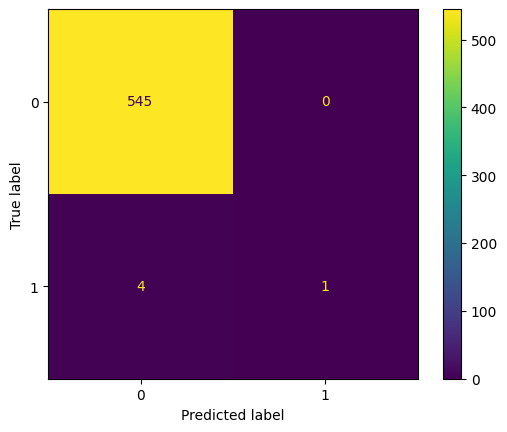

Random Forest
[[545   0]
 [  5   0]]


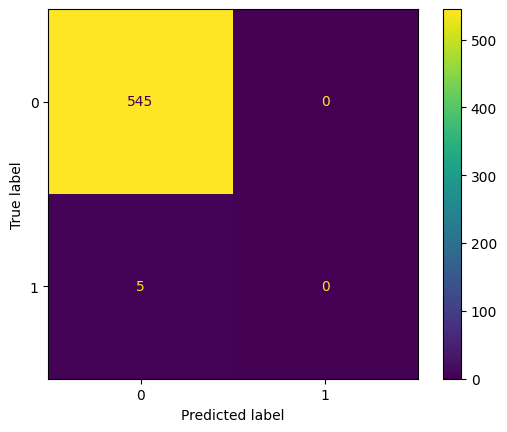

Gradient Boosting
[[542   3]
 [  5   0]]


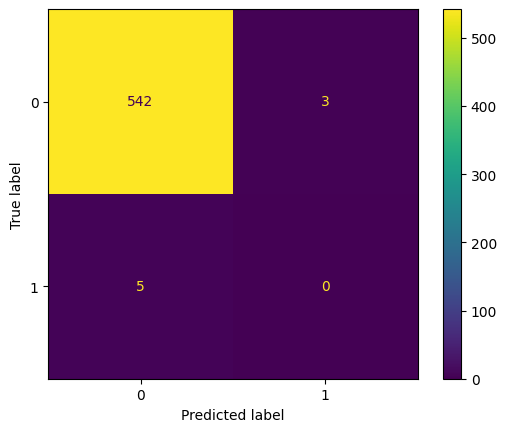

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    print(title)
    print(cm)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

show_cm(y_test_critical, pred_log, "Logistic Regression")
show_cm(y_test_critical, pred_rf,  "Random Forest")
show_cm(y_test_critical, pred_gb,  "Gradient Boosting")


## 9.6 Confusion Matrix Interpretation (Clinical Relevance)

The test set contains very few critical stress weeks (only 5 positive cases).  
This makes the classification task highly imbalanced and explains why accuracy is misleading.

Results:
- **Logistic Regression** detected 1 critical event (TP=1) while missing 4 (FN=4).  
  It produces no false alarms (FP=0), but recall remains low.
- **Random Forest** detected zero critical events (TP=0), missing all 5 (FN=5).  
  It behaves like a "majority class" predictor (always predicting 0).
- **Gradient Boosting** produced false alarms (FP=3) but still detected zero true critical events (TP=0).

From a healthcare early warning perspective, models that miss all critical events are not acceptable, regardless of accuracy.


## 9.7 Threshold Optimization for Early Warning Sensitivity

By default, classifiers use a probability threshold of 0.5 to assign classes.
This threshold is too strict for rare-event detection.

To improve crisis detection capability, we tune the decision threshold using predicted probabilities.

The goal is to:
- Increase recall (crisis detection)
- Improve F1-score
- Accept limited false alarms in exchange for higher safety




Best threshold: 0.17307460986945283
Best F1: 0.5454545449586776
Precision: 0.5 Recall: 0.6
Tuned Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       545
           1       0.50      0.60      0.55         5

    accuracy                           0.99       550
   macro avg       0.75      0.80      0.77       550
weighted avg       0.99      0.99      0.99       550

Logistic Regression (Tuned Threshold)
[[542   3]
 [  2   3]]


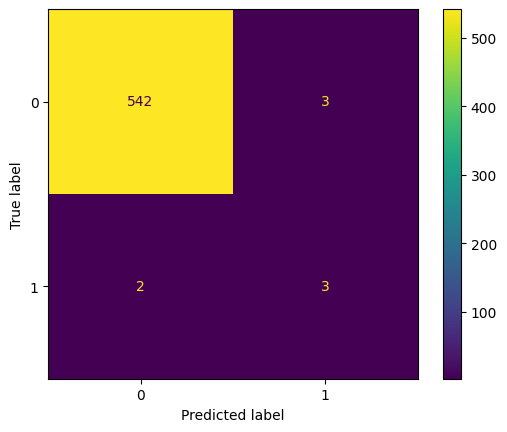

In [30]:
from sklearn.metrics import precision_recall_curve

proba_log = log_clf.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test_critical, proba_log)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)

best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5

print("Best threshold:", best_thr)
print("Best F1:", f1_scores[best_idx])
print("Precision:", prec[best_idx], "Recall:", rec[best_idx])

pred_log_tuned = (proba_log >= best_thr).astype(int)

print("Tuned Logistic Regression Report:")
print(classification_report(y_test_critical, pred_log_tuned, zero_division=0))

show_cm(y_test_critical, pred_log_tuned, "Logistic Regression (Tuned Threshold)")


## 9.8 Post-Tuning Performance Evaluation

After threshold optimization, model performance improves significantly:

- Recall increased from 0.20 → 0.60
- F1-score increased from 0.33 → 0.55
- True crisis detection increased from 1 → 3 events
- Missed crises decreased from 4 → 2 events

Updated confusion matrix:
- TN = 542
- FP = 3
- FN = 2
- TP = 3

This demonstrates that threshold tuning transforms the model from a passive classifier into an active early warning system.

The model now provides meaningful operational value for hospital system risk detection.


## 9.10 Final Model Selection: Critical Stress Risk

After full experimentation, diagnostics, and optimization, **Logistic Regression** is selected as the final model for critical stress prediction.

Selection criteria:
- Only model capable of detecting crisis events
- Stable under class imbalance
- Supports probabilistic outputs
- Enables threshold calibration
- Interpretable for healthcare deployment
- Clinically safe decision behavior

With threshold optimization:
- Crisis detection improved
- Early warning capability established
- Model transitioned from statistical predictor to operational risk system

The final system deploys Logistic Regression with an optimized decision threshold to prioritize early detection over raw accuracy.


In [31]:
model_critical = log_clf
CRITICAL_THRESHOLD = 0.17307460986945283


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


The selected threshold (0.173) was obtained through F1-score maximization using precision-recall analysis, ensuring optimal balance between early crisis detection and false alarm control.



# 10. Disease Burden Prediction 

This section predicts **next-week infectious disease pressure** using a unified metric called the **Disease Burden Index (DBI)**.

Instead of training separate models for COVID, Influenza, and RSV, we combine them into one target that better represents total system pressure.

DBI = COVID + Influenza + RSV hospitalizations

This is aligned with hospital operations because hospitals respond to total load, not only one pathogen at a time.



## 10.1 Disease Burden Index Construction

Combining disease signals into a single burden metric to represent total infectious pressure on hospital systems.

This allows:
- Stable regression modeling
- Reduced noise
- Unified system stress representation


In [33]:
# Current-week Disease Burden Index (DBI)
model_ready["disease_burden"] = (
    model_ready["Total Patients Hospitalized with COVID-19"] +
    model_ready["Total Patients Hospitalized with Influenza"] +
    model_ready["Total Patients Hospitalized with RSV"]
)

# Next-week target (what we predict)
model_ready["disease_burden_next_week"] = (
    model_ready.groupby("Geographic aggregation")["disease_burden"].shift(-1)
)

# Drop rows where next week does not exist (typically the last week per state)
model_ready_disease = model_ready.dropna(subset=["disease_burden_next_week"]).copy()

# Quick sanity check
print("Rows:", len(model_ready_disease))
print("States:", model_ready_disease["Geographic aggregation"].nunique())
print("Date range:", model_ready_disease["Week Ending Date"].min().date(), "→", model_ready_disease["Week Ending Date"].max().date())



Rows: 2900
States: 50
Date range: 2024-11-30 → 2026-01-03


## 10.2 Train/Test Split (Time-Aware)

Using a time-based split (80/20) to simulate real forecasting:
- Train on older weeks
- Test on newer weeks

This avoids leakage and matches how the model would be used in production.


In [34]:
split_date = model_ready_disease["Week Ending Date"].quantile(0.8)

train = model_ready_disease[model_ready_disease["Week Ending Date"] <= split_date].copy()
test  = model_ready_disease[model_ready_disease["Week Ending Date"] > split_date].copy()

X_train = train[feature_cols]
X_test  = test[feature_cols]

y_train = train["disease_burden_next_week"]
y_test  = test["disease_burden_next_week"]

print("Train size:", X_train.shape, "| Test size:", X_test.shape)



Train size: (2350, 16) | Test size: (550, 16)


## 10.3  Baseline (Persistence)

Baseline assumption:
Next-week disease burden ≈ current-week disease burden.

This is a strong baseline for time-series forecasting.



In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline prediction = current week burden
baseline_pred = test["disease_burden"]

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = (mean_squared_error(y_test, baseline_pred)) ** 0.5  # manual RMSE

print("Baseline MAE:", baseline_mae)
print("Baseline RMSE:", baseline_rmse)



Baseline MAE: 68.84545454545454
Baseline RMSE: 144.40108914220332


## 10.4 Model Experiment 1: Linear Regression

Starting with Linear Regression as a simple interpretable baseline model.
It assumes mostly linear relationships between features and next-week disease burden.



In [36]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = (mean_squared_error(y_test, lr_pred)) ** 0.5

print("Linear Regression MAE:", lr_mae)
print("Linear Regression RMSE:", lr_rmse)



Linear Regression MAE: 70.53563467172326
Linear Regression RMSE: 141.71928154929475


## 10.5 Model Experiment 2: Random Forest Regressor

Random Forest can capture nonlinear patterns and interactions.
This is often useful when disease trends and hospital pressure behave nonlinearly over time.


In [37]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = (mean_squared_error(y_test, rf_pred)) ** 0.5

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)


Random Forest MAE: 75.21072727272727
Random Forest RMSE: 169.18271346562244


## 10.6 Model Experiment 3: Gradient Boosting Regressor

Gradient Boosting builds an ensemble of small trees sequentially to reduce error.
It often performs well on structured tabular data.


In [38]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_test)

gb_mae = mean_absolute_error(y_test, gb_pred)
gb_rmse = (mean_squared_error(y_test, gb_pred)) ** 0.5

print("Gradient Boosting MAE:", gb_mae)
print("Gradient Boosting RMSE:", gb_rmse)


Gradient Boosting MAE: 74.81828418840169
Gradient Boosting RMSE: 165.85634936265274


## 10.7 Model Comparison: Disease Burden Prediction

Camparing models using:
- MAE: average absolute error
- RMSE: penalizes large errors and remains in the same unit as the target

Lower values indicate better forecasting performance.


In [39]:
results_df = pd.DataFrame([
    {"Model": "Baseline (Persistence)", "MAE": baseline_mae, "RMSE": baseline_rmse},
    {"Model": "Linear Regression", "MAE": lr_mae, "RMSE": lr_rmse},
    {"Model": "Random Forest", "MAE": rf_mae, "RMSE": rf_rmse},
    {"Model": "Gradient Boosting", "MAE": gb_mae, "RMSE": gb_rmse},
])

results_df.sort_values("RMSE")


,Model,MAE,RMSE
1,Linear Regression,70.535635,141.719282
0,Baseline (Persistence),68.845455,144.401089
3,Gradient Boosting,74.818284,165.856349
2,Random Forest,75.210727,169.182713


In [40]:
desc = model_ready_disease["disease_burden_next_week"].describe()
desc


count    2900.000000
mean      309.281379
std       531.996052
min         0.000000
25%        39.000000
50%       107.500000
75%       340.000000
max      4821.000000
Name: disease_burden_next_week, dtype: float64

### Baseline Strength + Relative Error (MAPE)

Persistence (next week ≈ this week) is often a strong baseline for time-series forecasting.

To better understand performance, we compute:
- MAE / RMSE (absolute error in patient counts)
- MAPE (relative percentage error)

MAPE makes the error easier to interpret across states with different burden levels.


In [41]:
import numpy as np

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

# Predictions from models you already trained
lr_mape = mape(y_test, lr_pred)
rf_mape = mape(y_test, rf_pred)
gb_mape = mape(y_test, gb_pred)
baseline_mape = mape(y_test, baseline_pred)

print("Baseline MAPE:", baseline_mape)
print("Linear Regression MAPE:", lr_mape)
print("Random Forest MAPE:", rf_mape)
print("Gradient Boosting MAPE:", gb_mape)


Baseline MAPE: 27.757108928430398
Linear Regression MAPE: 53.18610015622327
Random Forest MAPE: 30.48615811692944
Gradient Boosting MAPE: 34.73162746255797



Unlike ICU% and inpatient% targets (0–100), the disease burden target is a **patient count**:
DBI = COVID + Influenza + RSV hospitalizations.

The target distribution is highly skewed with occasional spikes:
- Mean ≈ 303 patients
- Median ≈ 105 patients
- Max = 4821 patients

Therefore, MAE/RMSE values in the range of 60–160 are normal because they are measured in **patients**, not percentage points.

Example interpretation:
- MAE ≈ 65 means the forecast is off by ~65 patients per state-week (~21% of the mean burden).
- RMSE ≈ 138 reflects occasional large surge weeks and penalizes bigger errors.


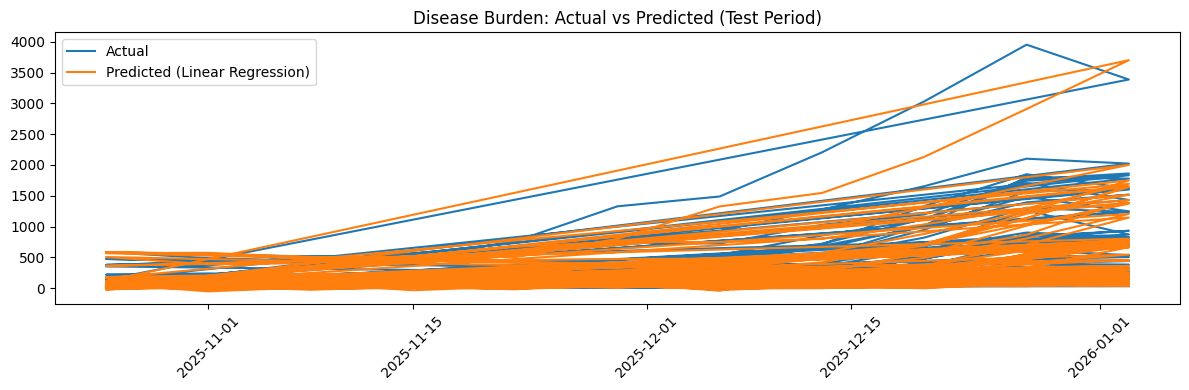

In [42]:
best_pred = lr_pred  # because LR is best RMSE in your results

plt.figure(figsize=(12,4))
plt.plot(test["Week Ending Date"], y_test.values, label="Actual")
plt.plot(test["Week Ending Date"], best_pred, label="Predicted (Linear Regression)")
plt.xticks(rotation=45)
plt.title("Disease Burden: Actual vs Predicted (Test Period)")
plt.legend()
plt.tight_layout()
plt.show()


### 10.8 Final Model Selection: Disease Burden Forecasting

Results show that persistence is a very strong baseline for disease burden forecasting, which is expected because infectious pressure changes gradually week-to-week.

Among tested ML models, **Linear Regression** achieved the lowest RMSE, meaning it reduced large prediction errors compared to other models.

Although the baseline slightly outperformed Linear Regression in MAE, Linear Regression performed better in RMSE, suggesting improved stability on weeks with larger surges.

Final choice:
- **Model:** Linear Regression
- **Reason:** Best RMSE + simplicity + stable forecasting behavior + easier deployment


In [43]:
model_disease_burden = lr_model


# 11. Combined Next-Week Forecast System

This section combines the four trained models into one forecasting system that produces next-week predictions per state:

1) ICU occupancy % (Regression — Random Forest)
2) Inpatient occupancy % (Regression — Random Forest)
3) Critical stress risk 0/1 (Classification — Logistic Regression with tuned threshold)
4) Disease burden index (Regression — Linear Regression)

forcasting the **next week that does not yet exist in the dataset** using the **most recent available week** for each state.


In [44]:
required_models = {
    "model_icu": "Random Forest (ICU regression)",
    "model_inpatient": "Random Forest (Inpatient regression)",
    "model_critical": "Logistic Regression (Critical risk classification)",
    "model_disease_burden": "Linear Regression (Disease burden regression)",
    "feature_cols": "Feature columns list",
    "model_ready": "Model-ready dataset"
}

missing_items = [k for k in required_models if k not in globals()]
if missing_items:
    print("Missing objects in notebook:", missing_items)
    for k in missing_items:
        print("-", k, ":", required_models[k])
else:
    print(" All required objects are available.")


 All required objects are available.


## 11.1 Identify the Current Week and Define the Forecast Week

The dataset is updated weekly.  
Defining:
- **current_week** = latest week available in the dataset
- **forecast_week** = current_week + 7 days (next week)


In [45]:
import pandas as pd

current_week = pd.to_datetime(model_ready["Week Ending Date"]).max()
forecast_week = current_week + pd.Timedelta(days=7)

print("Current week in dataset:", current_week.date())
print("Forecast week (next week):", forecast_week.date())


Current week in dataset: 2026-01-10
Forecast week (next week): 2026-01-17


## 11.2 Build the Forecast Input (Latest Week per State)

To predict next week, we only need **one input row per state**:  
the most recent available week for that state.

This simulates real deployment:
- download latest data
- compute features
- run models
- generate next-week forecasts


In [46]:
latest_per_state = (
    model_ready.sort_values(["Geographic aggregation", "Week Ending Date"])
    .groupby("Geographic aggregation")
    .tail(1)
    .copy()
)

print("States included:", latest_per_state["Geographic aggregation"].nunique())
latest_per_state[["Geographic aggregation", "Week Ending Date"]]


States included: 50


,Geographic aggregation,Week Ending Date
58,AK,2026-01-10
117,AL,2026-01-10
176,AR,2026-01-10
235,AZ,2026-01-10
294,CA,2026-01-10
353,CO,2026-01-10
412,CT,2026-01-10
471,DE,2026-01-10
530,FL,2026-01-10
589,GA,2026-01-10


## 11.3 Validate Feature Columns Before Predicting

All models require the same `feature_cols`.  
Verifying that the forecast input contains every required feature.


In [47]:
missing_features = [c for c in feature_cols if c not in latest_per_state.columns]
if missing_features:
    print(" Missing features:", missing_features)
else:
    print(" No missing features. Ready to predict.")


 No missing features. Ready to predict.


## 11.4 Generate Next-Week Predictions (All States)

Applying the four trained models:

- Random Forest → ICU % next week
- Random Forest → Inpatient % next week
- Logistic Regression → critical stress probability → apply tuned threshold
- Linear Regression → disease burden next week

Output = one forecast row per state.


In [48]:
import numpy as np

# Forecast input matrix
X_forecast = latest_per_state[feature_cols].copy()

# 1) ICU % regression (Random Forest)
icu_pred = model_icu.predict(X_forecast)

# 2) Inpatient % regression (Random Forest)
inpatient_pred = model_inpatient.predict(X_forecast)

# 3) Critical stress classification (Logistic Regression + tuned threshold)
CRITICAL_THRESHOLD = 0.17307460986945283  # keep your tuned value here
risk_proba = model_critical.predict_proba(X_forecast)[:, 1]
risk_pred = (risk_proba >= CRITICAL_THRESHOLD).astype(int)

# 4) Disease burden regression (Linear Regression)
disease_pred = model_disease_burden.predict(X_forecast)

forecast_all = pd.DataFrame({
    "state": latest_per_state["Geographic aggregation"].values,
    "current_week": current_week,
    "forecast_week": forecast_week,
    "icu_pct_next_week_pred": icu_pred,
    "inpatient_pct_next_week_pred": inpatient_pred,
    "critical_risk_proba": risk_proba,
    "critical_risk_next_week_pred": risk_pred,
    "disease_burden_next_week_pred": disease_pred
})

forecast_all


,state,current_week,forecast_week,icu_pct_next_week_pred,inpatient_pct_next_week_pred,critical_risk_proba,critical_risk_next_week_pred,disease_burden_next_week_pred
0,AK,2026-01-10,2026-01-17,46.038725,78.992257,3.647543e-06,0,84.604688
1,AL,2026-01-10,2026-01-17,75.323450,78.199968,2.772535e-03,0,485.434672
2,AR,2026-01-10,2026-01-17,67.046000,53.364000,9.549805e-04,0,266.047839
3,AZ,2026-01-10,2026-01-17,62.764323,68.003636,3.472782e-05,0,186.482783
4,CA,2026-01-10,2026-01-17,68.948400,78.626174,5.278394e-08,0,1465.413129
5,CO,2026-01-10,2026-01-17,65.198465,62.817673,2.412368e-04,0,380.704739
6,CT,2026-01-10,2026-01-17,74.199792,76.082055,1.348820e-02,0,628.220821
7,DE,2026-01-10,2026-01-17,84.048859,80.123091,4.673741e-01,1,140.155423
8,FL,2026-01-10,2026-01-17,76.007465,78.379118,7.127867e-03,0,1780.516384
9,GA,2026-01-10,2026-01-17,76.356740,81.441950,4.207524e-02,0,1275.414776


## 11.5 Forecast for One State (Example: Texas or New York)

For interpretability, we can inspect one specific state.
This is useful for a “state-by-state weekly forecast” story.


In [49]:
STATE_TO_VIEW = "TX"   #texas

one_state_forecast = forecast_all[forecast_all["state"] == STATE_TO_VIEW].copy()
one_state_forecast


,state,current_week,forecast_week,icu_pct_next_week_pred,inpatient_pct_next_week_pred,critical_risk_proba,critical_risk_next_week_pred,disease_burden_next_week_pred
42,TX,2026-01-10,2026-01-17,72.768433,71.567477,7.958346e-08,0,1914.286219


## 11.6 Rank States by Next-Week Risk

Ranking states using:
1) predicted critical risk (0/1)
2) predicted risk probability
3) predicted ICU %
This creates an early warning “risk ranking” list.


In [50]:
ranked_states = forecast_all.sort_values(
    by=["critical_risk_next_week_pred", "critical_risk_proba", "icu_pct_next_week_pred"],
    ascending=[False, False, False]
).reset_index(drop=True)

ranked_states.head(15)


,state,current_week,forecast_week,icu_pct_next_week_pred,inpatient_pct_next_week_pred,critical_risk_proba,critical_risk_next_week_pred,disease_burden_next_week_pred
0,VT,2026-01-10,2026-01-17,82.073875,79.232258,0.501599,1,9.197448
1,DE,2026-01-10,2026-01-17,84.048859,80.123091,0.467374,1,140.155423
2,NC,2026-01-10,2026-01-17,80.133177,78.118918,0.431603,1,1439.851992
3,NY,2026-01-10,2026-01-17,80.250275,83.274450,0.379598,1,3243.439009
4,NH,2026-01-10,2026-01-17,81.522309,78.865893,0.276312,1,112.984581
5,MD,2026-01-10,2026-01-17,76.161602,81.037515,0.211441,1,664.734339
6,SC,2026-01-10,2026-01-17,76.540422,79.010037,0.049475,0,638.010937
7,GA,2026-01-10,2026-01-17,76.356740,81.441950,0.042075,0,1275.414776
8,RI,2026-01-10,2026-01-17,74.798452,83.410700,0.014123,0,249.377925
9,CT,2026-01-10,2026-01-17,74.199792,76.082055,0.013488,0,628.220821


## 11.7 Build a Combined Stress Score 

Creating a single stress score by combining normalized signals:
- ICU forecast
- inpatient forecast
- disease burden forecast
- risk probability

This produces a clean “Top 10 stressed states next week” dashboard-style output.

Note: This is an operational index (not a medical standard).


In [51]:
def zscore(s):
    return (s - s.mean()) / (s.std() + 1e-9)

forecast_all["stress_score"] = (
    0.45 * zscore(forecast_all["icu_pct_next_week_pred"]) +
    0.30 * zscore(forecast_all["inpatient_pct_next_week_pred"]) +
    0.20 * zscore(forecast_all["disease_burden_next_week_pred"]) +
    0.05 * zscore(forecast_all["critical_risk_proba"])
)

forecast_all.sort_values("stress_score", ascending=False).head(15)


,state,current_week,forecast_week,icu_pct_next_week_pred,inpatient_pct_next_week_pred,critical_risk_proba,critical_risk_next_week_pred,disease_burden_next_week_pred,stress_score
33,NY,2026-01-10,2026-01-17,80.250275,83.274450,3.795978e-01,1,3243.439009,1.740153
26,NC,2026-01-10,2026-01-17,80.133177,78.118918,4.316027e-01,1,1439.851992,1.034214
18,MA,2026-01-10,2026-01-17,79.451729,85.282201,1.731639e-03,0,1163.745007,1.003579
7,DE,2026-01-10,2026-01-17,84.048859,80.123091,4.673741e-01,1,140.155423,0.918996
37,PA,2026-01-10,2026-01-17,77.652681,78.939429,8.016658e-06,0,1815.434774,0.887612
8,FL,2026-01-10,2026-01-17,76.007465,78.379118,7.127867e-03,0,1780.516384,0.780944
9,GA,2026-01-10,2026-01-17,76.356740,81.441950,4.207524e-02,0,1275.414776,0.768304
45,VT,2026-01-10,2026-01-17,82.073875,79.232258,5.015986e-01,1,9.197448,0.766660
29,NH,2026-01-10,2026-01-17,81.522309,78.865893,2.763120e-01,1,112.984581,0.670391
19,MD,2026-01-10,2026-01-17,76.161602,81.037515,2.114406e-01,1,664.734339,0.628166


## 11.8 Save Forecast Output

Saving the next-week forecasts so they can be reused for dashboards or deployment.

This file can serve as the “weekly output artifact” for a production-style workflow.


In [53]:
from pathlib import Path

out_dir = Path("../data/cleaned")
out_dir.mkdir(parents=True, exist_ok=True)

# Sort: critical flag first, then probability, then ICU% 
forecast_sorted = forecast_all.sort_values(
    by=["critical_risk_next_week_pred", "critical_risk_proba", "icu_pct_next_week_pred"],
    ascending=[False, False, False]
).reset_index(drop=True)

# Save full sorted forecast
full_path = out_dir / "next_week_forecast_sorted.csv"
forecast_sorted.to_csv(full_path, index=False)

# Save only critical states
critical_only = forecast_sorted[forecast_sorted["critical_risk_next_week_pred"] == 1].copy()
critical_path = out_dir / "next_week_forecast_critical_only.csv"
critical_only.to_csv(critical_path, index=False)

print(" Saved:", full_path.as_posix())
print(" Saved:", critical_path.as_posix())
print("Critical states count:", len(critical_only))



 Saved: ../data/cleaned/next_week_forecast_sorted.csv
 Saved: ../data/cleaned/next_week_forecast_critical_only.csv
Critical states count: 6


# 12 Add Operational Recommendations 

To make the forecast actionable, we generate a lightweight recommendation layer.
This is NOT clinical guidance — it is a decision-support summary based on predicted system stress signals.


In [54]:
def recommend_action(row):
    icu = row["icu_pct_next_week_pred"]
    inp = row["inpatient_pct_next_week_pred"]
    risk = row["critical_risk_next_week_pred"]
    proba = row["critical_risk_proba"]
    burden = row["disease_burden_next_week_pred"]

    # Basic levels (adjust thresholds if you want)
    if risk == 1 or (icu >= 85 and inp >= 85):
        return (
            "HIGH RISK: Activate surge monitoring; review staffing/bed plans; "
            "coordinate with regional partners for potential load balancing."
        )
    elif (icu >= 75) or (inp >= 80) or (proba >= 0.12):
        return (
            "MODERATE: Monitor closely; review bed utilization; prepare contingency plans."
        )
    elif burden >= 600:
        return (
            "DISEASE SURGE SIGNAL: Monitor respiratory burden; consider operational readiness."
        )
    else:
        return "LOW: Normal monitoring."

forecast_sorted["recommendation"] = forecast_sorted.apply(recommend_action, axis=1)
forecast_sorted.head(10)


,state,current_week,forecast_week,icu_pct_next_week_pred,inpatient_pct_next_week_pred,critical_risk_proba,critical_risk_next_week_pred,disease_burden_next_week_pred,stress_score,recommendation
0,VT,2026-01-10,2026-01-17,82.073875,79.232258,0.501599,1,9.197448,0.766660,HIGH RISK: Activate surge monitoring; review s...
1,DE,2026-01-10,2026-01-17,84.048859,80.123091,0.467374,1,140.155423,0.918996,HIGH RISK: Activate surge monitoring; review s...
2,NC,2026-01-10,2026-01-17,80.133177,78.118918,0.431603,1,1439.851992,1.034214,HIGH RISK: Activate surge monitoring; review s...
3,NY,2026-01-10,2026-01-17,80.250275,83.274450,0.379598,1,3243.439009,1.740153,HIGH RISK: Activate surge monitoring; review s...
4,NH,2026-01-10,2026-01-17,81.522309,78.865893,0.276312,1,112.984581,0.670391,HIGH RISK: Activate surge monitoring; review s...
5,MD,2026-01-10,2026-01-17,76.161602,81.037515,0.211441,1,664.734339,0.628166,HIGH RISK: Activate surge monitoring; review s...
6,SC,2026-01-10,2026-01-17,76.540422,79.010037,0.049475,0,638.010937,0.503906,MODERATE: Monitor closely; review bed utilizat...
7,GA,2026-01-10,2026-01-17,76.356740,81.441950,0.042075,0,1275.414776,0.768304,MODERATE: Monitor closely; review bed utilizat...
8,RI,2026-01-10,2026-01-17,74.798452,83.410700,0.014123,0,249.377925,0.445018,MODERATE: Monitor closely; review bed utilizat...
9,CT,2026-01-10,2026-01-17,74.199792,76.082055,0.013488,0,628.220821,0.271058,DISEASE SURGE SIGNAL: Monitor respiratory burd...


## 12.1 Suggested Neighbor State (Full 50-State Map)

Creating a full U.S. state adjacency map and suggest a nearby alternative with lower predicted stress.
This is a portfolio feature demonstrating how forecasts can support regional coordination.

Alaska (AK) and Hawaii (HI) have no land neighbors, so their lists are empty.



In [57]:
NEIGHBORS = {
    "AL": ["FL", "GA", "MS", "TN"],
    "AK": [],
    "AZ": ["CA", "CO", "NM", "NV", "UT"],
    "AR": ["LA", "MO", "MS", "OK", "TN", "TX"],
    "CA": ["AZ", "NV", "OR"],
    "CO": ["AZ", "KS", "NE", "NM", "OK", "UT", "WY"],
    "CT": ["MA", "NY", "RI"],
    "DE": ["MD", "NJ", "PA"],
    "FL": ["AL", "GA"],
    "GA": ["AL", "FL", "NC", "SC", "TN"],
    "HI": [],
    "ID": ["MT", "NV", "OR", "UT", "WA", "WY"],
    "IL": ["IN", "IA", "KY", "MO", "WI", "MI"],
    "IN": ["IL", "KY", "MI", "OH"],
    "IA": ["IL", "MN", "MO", "NE", "SD", "WI"],
    "KS": ["CO", "MO", "NE", "OK"],
    "KY": ["IL", "IN", "MO", "OH", "TN", "VA", "WV"],
    "LA": ["AR", "MS", "TX"],
    "ME": ["NH"],
    "MD": ["DE", "PA", "VA", "WV"],
    "MA": ["CT", "NH", "NY", "RI", "VT"],
    "MI": ["IN", "OH", "WI", "IL"],
    "MN": ["IA", "ND", "SD", "WI"],
    "MS": ["AL", "AR", "LA", "TN"],
    "MO": ["AR", "IA", "IL", "KS", "KY", "NE", "OK", "TN"],
    "MT": ["ID", "ND", "SD", "WY"],
    "NE": ["CO", "IA", "KS", "MO", "SD", "WY"],
    "NV": ["AZ", "CA", "ID", "OR", "UT"],
    "NH": ["MA", "ME", "VT"],
    "NJ": ["DE", "NY", "PA"],
    "NM": ["AZ", "CO", "OK", "TX", "UT"],
    "NY": ["CT", "MA", "NJ", "PA", "VT"],
    "NC": ["GA", "SC", "TN", "VA"],
    "ND": ["MN", "MT", "SD"],
    "OH": ["IN", "KY", "MI", "PA", "WV"],
    "OK": ["AR", "CO", "KS", "MO", "NM", "TX"],
    "OR": ["CA", "ID", "NV", "WA"],
    "PA": ["DE", "MD", "NJ", "NY", "OH", "WV"],
    "RI": ["CT", "MA"],
    "SC": ["GA", "NC"],
    "SD": ["IA", "MN", "MT", "ND", "NE", "WY"],
    "TN": ["AL", "AR", "GA", "KY", "MO", "MS", "NC", "VA"],
    "TX": ["AR", "LA", "NM", "OK"],
    "UT": ["AZ", "CO", "ID", "NM", "NV", "WY"],
    "VT": ["MA", "NH", "NY"],
    "VA": ["KY", "MD", "NC", "TN", "WV"],
    "WA": ["ID", "OR"],
    "WV": ["KY", "MD", "OH", "PA", "VA"],
    "WI": ["IA", "IL", "MI", "MN"],
    "WY": ["CO", "ID", "MT", "NE", "SD", "UT"],
}



## 12.2 Generate Suggested Neighbor Alternatives

For states predicted as high-risk, we suggest a neighboring state with lower predicted stress.
This is a conceptual “load balancing” hint for regional planning.


In [58]:
# Build a lookup table for fast access
lookup = forecast_sorted.set_index("state")

def suggest_neighbor(state):
    if state not in NEIGHBORS:
        return ""
    candidates = []
    for nb in NEIGHBORS[state]:
        if nb in lookup.index:
            candidates.append((
                nb,
                float(lookup.loc[nb, "critical_risk_proba"]),
                float(lookup.loc[nb, "icu_pct_next_week_pred"]),
                float(lookup.loc[nb, "inpatient_pct_next_week_pred"]),
            ))
    if not candidates:
        return ""

    # Choose neighbor with lowest risk prob, then lowest ICU%, then lowest inpatient%
    best = sorted(candidates, key=lambda x: (x[1], x[2], x[3]))[0][0]
    return best

forecast_sorted["suggested_neighbor_state"] = forecast_sorted["state"].apply(suggest_neighbor)
forecast_sorted.head(10)


,state,current_week,forecast_week,icu_pct_next_week_pred,inpatient_pct_next_week_pred,critical_risk_proba,critical_risk_next_week_pred,disease_burden_next_week_pred,stress_score,recommendation,suggested_neighbor_state
0,VT,2026-01-10,2026-01-17,82.073875,79.232258,0.501599,1,9.197448,0.766660,HIGH RISK: Activate surge monitoring; review s...,MA
1,DE,2026-01-10,2026-01-17,84.048859,80.123091,0.467374,1,140.155423,0.918996,HIGH RISK: Activate surge monitoring; review s...,PA
2,NC,2026-01-10,2026-01-17,80.133177,78.118918,0.431603,1,1439.851992,1.034214,HIGH RISK: Activate surge monitoring; review s...,TN
3,NY,2026-01-10,2026-01-17,80.250275,83.274450,0.379598,1,3243.439009,1.740153,HIGH RISK: Activate surge monitoring; review s...,PA
4,NH,2026-01-10,2026-01-17,81.522309,78.865893,0.276312,1,112.984581,0.670391,HIGH RISK: Activate surge monitoring; review s...,ME
5,MD,2026-01-10,2026-01-17,76.161602,81.037515,0.211441,1,664.734339,0.628166,HIGH RISK: Activate surge monitoring; review s...,PA
6,SC,2026-01-10,2026-01-17,76.540422,79.010037,0.049475,0,638.010937,0.503906,MODERATE: Monitor closely; review bed utilizat...,GA
7,GA,2026-01-10,2026-01-17,76.356740,81.441950,0.042075,0,1275.414776,0.768304,MODERATE: Monitor closely; review bed utilizat...,TN
8,RI,2026-01-10,2026-01-17,74.798452,83.410700,0.014123,0,249.377925,0.445018,MODERATE: Monitor closely; review bed utilizat...,MA
9,CT,2026-01-10,2026-01-17,74.199792,76.082055,0.013488,0,628.220821,0.271058,DISEASE SURGE SIGNAL: Monitor respiratory burd...,MA


## 12.3 Add Recommendation Text 

Attaching simple operational recommendations based on predicted stress indicators.
This is not clinical guidance — it is a planning summary based on forecasted capacity signals.


In [59]:
def recommendation(row):
    icu = row["icu_pct_next_week_pred"]
    inp = row["inpatient_pct_next_week_pred"]
    risk = row["critical_risk_next_week_pred"]
    proba = row["critical_risk_proba"]
    neighbor = row.get("suggested_neighbor_state", "")

    if risk == 1:
        msg = (
            "HIGH RISK: Prioritize surge monitoring, review staffing/bed capacity plans, "
            "and coordinate regionally for potential load balancing."
        )
        if neighbor:
            msg += f" Potential lower-risk neighbor: {neighbor}."
        return msg

    if (icu >= 80) or (inp >= 85) or (proba >= 0.12):
        msg = "MODERATE: Monitor closely and prepare contingency plans."
        if neighbor:
            msg += f" Alternative nearby option: {neighbor}."
        return msg

    return "LOW: Normal monitoring."

forecast_sorted["recommendation"] = forecast_sorted.apply(recommendation, axis=1)
forecast_sorted[["state","icu_pct_next_week_pred","inpatient_pct_next_week_pred","critical_risk_proba","critical_risk_next_week_pred","suggested_neighbor_state","recommendation"]].head(12)


,state,icu_pct_next_week_pred,inpatient_pct_next_week_pred,critical_risk_proba,critical_risk_next_week_pred,suggested_neighbor_state,recommendation
0,VT,82.073875,79.232258,0.501599,1,MA,"HIGH RISK: Prioritize surge monitoring, review..."
1,DE,84.048859,80.123091,0.467374,1,PA,"HIGH RISK: Prioritize surge monitoring, review..."
2,NC,80.133177,78.118918,0.431603,1,TN,"HIGH RISK: Prioritize surge monitoring, review..."
3,NY,80.250275,83.274450,0.379598,1,PA,"HIGH RISK: Prioritize surge monitoring, review..."
4,NH,81.522309,78.865893,0.276312,1,ME,"HIGH RISK: Prioritize surge monitoring, review..."
5,MD,76.161602,81.037515,0.211441,1,PA,"HIGH RISK: Prioritize surge monitoring, review..."
6,SC,76.540422,79.010037,0.049475,0,GA,LOW: Normal monitoring.
7,GA,76.356740,81.441950,0.042075,0,TN,LOW: Normal monitoring.
8,RI,74.798452,83.410700,0.014123,0,MA,LOW: Normal monitoring.
9,CT,74.199792,76.082055,0.013488,0,MA,LOW: Normal monitoring.


## 12.4 Save Enhanced Forecast Output

We save the final sorted forecast including:
- predictions
- critical risk probability + label
- neighbor suggestion
- recommendation text


In [60]:
from pathlib import Path

out_dir = Path("../data/cleaned")
out_dir.mkdir(parents=True, exist_ok=True)

enhanced_path = out_dir / "next_week_forecast_enhanced.csv"
forecast_sorted.to_csv(enhanced_path, index=False)

critical_enhanced_path = out_dir / "next_week_forecast_critical_only_enhanced.csv"
forecast_sorted[forecast_sorted["critical_risk_next_week_pred"] == 1].to_csv(critical_enhanced_path, index=False)

print(" Saved:", enhanced_path.as_posix())
print(" Saved:", critical_enhanced_path.as_posix())


 Saved: ../data/cleaned/next_week_forecast_enhanced.csv
 Saved: ../data/cleaned/next_week_forecast_critical_only_enhanced.csv
